In [2]:
import numpy as np
import copy
from matplotlib import pyplot as plt

In [6]:
# 单目标pso-w 优化方法
class ParticalSwarmOptimization:

    def __init__(self, target_func=None, x_interval=[-3, 3], particle_size=100,
                 iter_round=100, inertial_weight=0.9,
                 c1=2, c2=2, partical_max_vel=0.5):
        self.target_func = target_func  # 适应度函数
        self.x_min = x_interval[0]  # 解范围-最小值
        self.x_max = x_interval[1]  # 解范围-最大值

        self.particle_size = particle_size  # 粒子个数
        self.particle_max_vel = partical_max_vel  # 粒子最大速度

        self.particle_pos = []  # 各粒子的位置（也就是变量x的值）
        self.particle_vel = []  # 各粒子的初始速度
        self.particle_fitness = []  # 各粒子的适应度

        self.particle_pb_pos = [] # 粒子个体最优位置
        self.particle_pb_fitness = []  # 粒子个体最优适应度
        
        self.particle_gb_pos = []   # 粒子群全局最优位置
        self.particle_gb_fitness = 0  # 粒子群全局最优适应度

        self.inertial_weight = inertial_weight  # 粒子惯性权重
        self.param_c1 = c1  # 位置更新常数系数
        self.param_c2 = c2  # 位置更新常数系数
        self.iter_round = iter_round  # PSO算法迭代次数

        self.record_particles_fitness_mean_iter = []  # 记录粒子群适应度均值随迭代过程变化
        self.record_gb_pos_iter = []  # 记录全局最优位置随迭代过程变化
        self.record_gb_fitness_iter = [] # 记录全局最优适应度随迭代过程变化
        self.record_gb_function_val_iter = []  # # 记录全局最优位置对应的函数值随迭代过程变化
    
    # 计算函数值
    def __evaluate_func_val(self, particle_pos):
        return self.target_func(particle_pos)
    
    # sigmoid适应度函数
    def __sigmoid(self, val):
        return 1/(1 + np.exp(-val))
    
    # 根据粒子位置计算适应度，将函数值进行sigmoid转换
    def __evaluate_fitness(self, particle_pos):
        return self.__sigmoid(self.__evaluate_func_val(particle_pos))
    
    # 初始化粒子位置、速度、以及计算对应粒子的适应度
    def particle_init(self):
        rand_point = np.random.rand(self.particle_size)
        self.particle_pos = [self.x_min + (self.x_max - self.x_min)*rand_point[index] 
                             for index in range(self.particle_size)]
        self.particle_vel = [self.particle_max_vel*rand_point[index] for index in range(self.particle_size)]
        self.particle_fitness = [self.__evaluate_fitness(self.particle_pos[index])
                                 for index in range(self.particle_size)]
        self.particle_pb_pos = copy.deepcopy(self.particle_pos)
        self.particle_pb_fitness = copy.deepcopy(self.particle_fitness)
        
        self.particle_gb_pos = copy.deepcopy(self.particle_pb_pos[np.argmax(self.particle_pb_fitness)])
        self.particle_gb_fitness = np.max(self.particle_pb_fitness)
        
    # 算法停止控制
    def stop_control(self, iter_round):
        return iter_round >= self.iter_round
    
    # 更新粒子个体最优位置、适应度和全局最优位置和适应度
    def update_pb_and_gb(self):
        for particle_index in range(self.particle_size):
            if self.particle_fitness[particle_index] > self.particle_pb_fitness[particle_index]:
                # 个体最优位置
                self.particle_pb_pos[particle_index] = self.particle_pos[particle_index]
                # 个体最优适应度
                self.particle_pb_fitness[particle_index] = self.particle_fitness[particle_index]
        if np.max(self.particle_pb_fitness) > self.particle_gb_fitness:
            # 全局最优位置
            self.particle_gb_pos = self.particle_pb_pos[np.argmax(self.particle_pb_fitness)]
            # 全局最优适应度
            self.particle_gb_fitness = np.max(self.particle_pb_fitness)
            
    # 更新粒子位置、速度和适应度
    def update_particles(self):
        rand_points = np.random.rand(2)
        for particle_index in range(self.particle_size):
            part_1 = self.param_c1*rand_points[0]*(self.particle_pb_pos[particle_index] - 
                                                    self.particle_pos[particle_index])
            part_2 = self.param_c2*rand_points[1]*(self.particle_gb_pos - 
                                                    self.particle_pos[particle_index])
            # 更新速度
            self.particle_vel[particle_index] = self.inertial_weight*self.particle_vel[particle_index] \
                                                + part_1 + part_2
            # 更新位置
            self.particle_pos[particle_index] = self.particle_pos[particle_index] \
                                                + self.particle_vel[particle_index] 
            # 更新适应度
            self.particle_fitness[particle_index] = self.__evaluate_fitness(self.particle_pos[particle_index])
        
    # 记录粒子群适应度均值， 全局最优位置，
    # 以及全局最优适应度，全局最优位置对应的函数值随迭代过程的变化
    def iter_record(self):
        self.record_particles_fitness_mean_iter.append(np.mean(self.particle_fitness))
        self.record_gb_pos_iter.append(self.particle_gb_pos)
        self.record_gb_fitness_iter.append(self.particle_gb_fitness)
        self.record_gb_function_val_iter.append(self.__evaluate_func_val(self.particle_gb_pos))
        
    # 画出粒子群适应度均值， 全局最优位置，
    # 以及全局最优适应度，全局最优位置对应的函数值随迭代过程的变化
    def plot_iter(self, pic_save_dir):
        x = [iter_i for iter_i in range(1,len(self.record_particles_fitness_mean_iter)+1)]
        y_list = [self.record_particles_fitness_mean_iter, self.record_gb_pos_iter, 
                  self.record_gb_fitness_iter,self.record_gb_function_val_iter]
        y_lable_list = ['pso_mean_fitness','pso_gb_pos','pso_gb_fitness','pso_gb_function_val']
        for y_index in range(len(y_list)):
            plt.plot(x, y_list[y_index],label=y_lable_list[y_index])
            plt.title(y_lable_list[y_index])
            plt.xlabel(r'iter_round')
            plt.ylabel(y_lable_list[y_index])
            plt.savefig(pic_save_dir + r'\\' + y_lable_list[y_index] + '.png')
            plt.show()
        pass
    
    #  函数主程
    def pso_engine(self,pic_save_dir):
        iter_round = 0
        # 初始化粒子
        self.particle_init()
        while True:
            if not self.stop_control(iter_round):
                # 更新粒子位置、速度和适应度
                self.update_particles()
                # 更新粒子个体最优位置、适应度和全局最优位置和适应度
                self.update_pb_and_gb()
                # 迭代过程中各指标记录
                self.iter_record()
                iter_round += 1
                continue
            break
        print('PSO Algorythmn:')
        print('Best solution of variable x:', self.particle_gb_pos)
        print('The fitness of best solution:', self.particle_gb_fitness)
        print('Best function val of x:', self.__evaluate_func_val(self.particle_gb_pos))
        return self.plot_iter(pic_save_dir)

In [7]:
target_func = lambda x: -(x+2)*(x+1)*(x-3)*(x-4)
pic_save_dir = r'D:\WORK__wells\Other Program\Function Solution'

PSO Algorythmn:
Best solution of variable x: 3.5495066580513868
The fitness of best solution: 0.9980732653361926
Best function val of x: 6.249999999750342


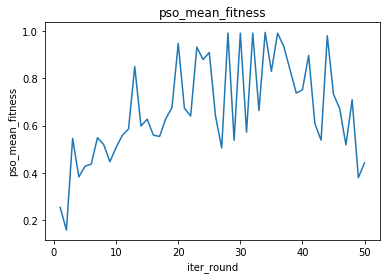

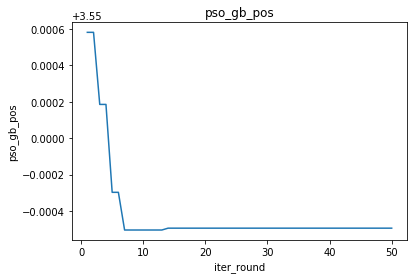

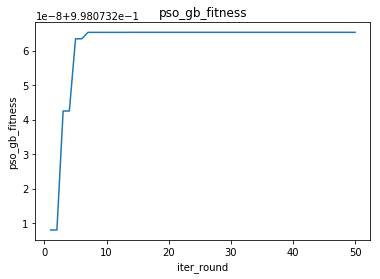

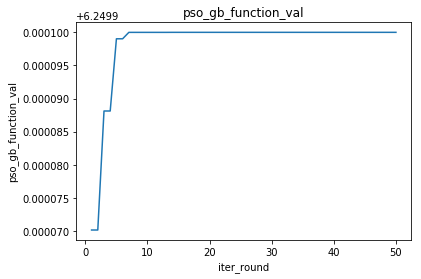

In [8]:
pso_test = ParticalSwarmOptimization(target_func,
                                     x_interval=[0, 10], particle_size=500,iter_round=50, 
                                     inertial_weight=0.8, c1=2, c2=2,partical_max_vel=0.05)
pso_test.pso_engine(pic_save_dir)